# **Machine Learning Group Project:** Recommender System Preparation

The purpose of this notebook is to extract content-based similarities across different products on the basis of the plethora of of textual data contained in descriptive columns such as _tags_, _genres_, _description_, or _steamspy_tags_. These findings can later be utilized when building other models.

In [1]:
# General
import requests
import string
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
from kneed import KneeLocator
import matplotlib.pyplot as plt

# Sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Content-Based Similarity

### Text Data DataFrame

First we create a DataFrame that contains all instances of descriptive textual data for the products. There is a single entry for each game. We run an inner merge because this is the same kind of merge done between these datasets for the final_df in [a_csv_creation.ipynb](a_csv_creation.ipynb). Consequently, this ensures the data we are working with is compatible with other work later on.

In [2]:
# Import the final DataFrame
textual_df = pd.read_csv("data/final_df.csv", 
                       usecols = ["app_id", "title",
                                  "categories", "genres",
                                  "steamspy_tags", "description",
                                  "tags"])

In [3]:
textual_df.drop_duplicates(subset=['title'], inplace=True)
textual_df.reset_index(drop = True, inplace = True)

textual_df.head(3)

,app_id,title,description,tags,genres,steamspy_tags,categories
0,244850,Space Engineers,Space Engineers is a sandbox game about engine...,"['Space', 'Sandbox', 'Building', 'Open World S...",Action;Indie;Simulation;Strategy,Space;Sandbox;Building,Single-player;Multi-player;Online Multi-Player...
1,489520,Minion Masters,An addictive fast-paced hybrid of Card games &...,"['Real Time Tactics', 'RTS', 'Multiplayer', 'C...",Action;Free to Play;Indie;Strategy;Early Access,Early Access;Strategy;Card Game,Multi-player;Online Multi-Player;Co-op;Online ...
2,394360,Hearts of Iron IV,Victory is at your fingertips! Your ability to...,"['Strategy', 'World War II', 'Grand Strategy',...",Simulation;Strategy,Strategy;World War II;Grand Strategy,Single-player;Multi-player;Co-op;Cross-Platfor...


### Data Preparation

#### Text Homogenization

The first step undertaken is homgenizing the text across the different columns. We do the following:
- Make all words fully lowercase
- Transform the _tags_ column from a list to a string
- Remove separators in the strings of columns such as _categories_, _steamspy_tags_, etc.
- Remove any other punctuation
- Homogenize words with spelling discrepancies (e.g. multiplayer & multi-player)

Note that we do not remove duplicates (e.g. a game being described as "Action" under _genres_ and _steamspy_tags_) because we believe if a word is utilized by more than one source, it should have a stronger weight when vectorizing. 

In [4]:
# Turn to String
textual_df["tags"] = textual_df["tags"].astype(str)

# Remove all punctuation and make everything lowercase
textual_df["tags"] = textual_df["tags"].str.translate(str.maketrans('', '', string.punctuation)).str.lower()

In [7]:
# Use vectorized operations to remove separators from list columns and turn all to lowercase
for col in ["categories", "genres", "steamspy_tags", "tags"]:
    textual_df[col] = textual_df[col].str.replace(';', ' ').str.lower()

    textual_df[col] = textual_df[col].str.replace("multi-player", "multiplayer")\
        .str.replace("free to play", "free-to-play").str.replace("singleplayer", "single-player")\
        .str.replace("post-apocalyptic", "postapocalyptic").str.replace("scifi", "sci-fi")\
        .str.replace("anti cheat", "anti-cheat").str.replace("early access", "early-access")\
        .str.replace("shared/split screen", "shared/split-screen").str.replace(" &", "")\
        .str.replace("sexual content", "sexual").str.replace(" \(require", "").str.replace(" hl2\)", "")\
        .str.replace("massively multiplayer", "massive-multiplayer")\
        .str.replace("in-app purchases", "in-app-purcases").str.replace("perma death", "permadeath")\
        .str.replace("third person", "third-person").str.replace("multiple endings","multi-ending")\
        .str.replace("1990's", "1990s").str.replace("25d", "2.5d").str.replace("shoot 'em", "shoot'em")

C:\Users\utente\AppData\Local\Temp\ipykernel_2448\3824489894.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  textual_df[col] = textual_df[col].str.replace("multi-player", "multiplayer")\


In [8]:
# Define punctuation and numbers
punc = '''!()[]{};:'"\,<>./?@#$%^&*_~'''
num = '0123456789'

# Remove punctuation, numbers, and turn description to lowercase 
textual_df["description"] = textual_df["description"].str.replace(f'[{punc+num}]', '', regex=True)\
    .str.lower().str.replace("multi-player", "multiplayer")

#### Stopword Removal

Although columns like _categories_, _genres_, _steamspy_tags_, and _tags_ do not suffer from this issue, the _description_ column contains stopwords which could be detrimental to our analysis. The stopword list is obtained from a separate [GitHub project](https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt).

In [9]:
# Obtain stopwords
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = set(stopwords_list.decode().splitlines()) 

# Remove Stopwords
textual_df['description'] = textual_df['description']\
.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

#### Full Text Column Creation

Finally, we create a new column which contains all the textual information we have on a game.   

In [10]:
textual_df['full_text'] = textual_df['categories'] + ' ' + textual_df['genres'] + ' ' + textual_df['steamspy_tags'] + ' ' + textual_df['description'] + ' ' + textual_df['tags']

### Text Data Exploration

We dedicate a section to exploring text data and truly understanding the breadth of data and labels which are available on textual_df.

**Number of Distinct Labels:** All four labelling columns feature different tag systems with wholly different labels (and variety thereof). Here we check how these vary in terms of numbers. While _categories_ and _genres_ have a relatively restrained count of unique labels (41 and 25 respectively), _tags_ and _steamspy_tags_ have much greater breadth (with 479 and 373 respectively). 

In [11]:
for i in ["categories", "genres", "steamspy_tags", "tags"]:
    split_count = len(textual_df[i].str.split(' ', expand=True).stack().unique())
    print(f"The \033[1m'{i}' column\033[0m features a total of \033[1m{split_count} distinct labels\033[0m.")

The 'categories' column features a total of 35 distinct labels.
The 'genres' column features a total of 23 distinct labels.
The 'steamspy_tags' column features a total of 169 distinct labels.
The 'tags' column features a total of 375 distinct labels.


**Average Number of Labels per Game:** While there is a great difference in the number of unique labels, the average number of labels assigned to a single game is on average quite stable. In fact, _genres_, _steamspy_tags_, and _tags_ all approximately have the same number of labels per row (to two decimal figures). Despite having the second lowest number of different labels, _categories_ has the highest number of labels per row: 8.12.

In [12]:
for i in ["categories", "genres", "steamspy_tags", "tags"]:
    
    split = [len(j) for j in textual_df[i].str.split(' ', expand=True).stack()]
    split_mean = sum(split) / len(split)
    
    print("The entries in the\033[1m", f"'{i}'", "column\033[0m have an approximate average of\033[1m", 
          round(split_mean,2), "labels per row\033[0m.") 

The entries in the 'categories' column have an approximate average of 7.73 labels per row.
The entries in the 'genres' column have an approximate average of 7.91 labels per row.
The entries in the 'steamspy_tags' column have an approximate average of 7.15 labels per row.
The entries in the 'tags' column have an approximate average of 7.17 labels per row.


**Most Common Labels:** AAAAA WE INVESTIGATE

In [13]:
for i in ["categories", "genres", "steamspy_tags", "tags"]:
    
    split_count = textual_df[i].str.split(' ', expand=True).stack().value_counts()
    
    print("The most frequently recurring tags (along with their occurrence) in the", f"'{i}'",
          "column:", f"\n{split_count.nlargest(10)}\n")

The most frequently recurring tags (along with their occurrence) in the 'categories' column: 
steam            644
multiplayer      295
single-player    260
support          209
achievements     207
controller       202
trading          182
cards            182
co-op            168
online           158
dtype: int64

The most frequently recurring tags (along with their occurrence) in the 'genres' column: 
action                 168
indie                  108
adventure               94
simulation              87
rpg                     73
strategy                72
early-access            51
free-to-play            40
massive-multiplayer     40
casual                  25
dtype: int64

The most frequently recurring tags (along with their occurrence) in the 'steamspy_tags' column: 
action          65
strategy        54
world           54
early-access    51
multiplayer     49
rpg             49
open            47
survival        37
free-to-play    35
simulation      35
dtype: int64

The mos

**Tag Intersection:** Finally, we check if there are certain tags which exist in multiple columns (e.g. "action" being an entry in the _genres_, but also in _tags_. We find that there are AAAAAAAAAA

In [14]:
# Get the unique values in each column
categories = set(textual_df['categories'].str.split(' ').explode().str.strip())
tags = set(textual_df['tags'].str.split(' ').explode().str.strip())
steamspy_tags = set(textual_df['steamspy_tags'].str.split(' ').explode().str.strip())
genre = set(textual_df['genres'].str.split(' ').explode().str.strip())

# Find the intersection of the sets to get the values that exist in all four columns
or_intersection = categories | tags | steamspy_tags | genre
and_intersection = categories & tags & steamspy_tags & genre

# Print the number of unique values that exist in all four columns
print("The number of labels present in at least two columns is:", len(or_intersection))
print("The number of labels present in all four columns is:", len(and_intersection))

The number of labels present in at least two columns is: 410
The number of labels present in all four columns is: 0


#### Textual Data Vectorization

First we create a vector containing information concerning the textual descriptions of the games. We display the first three rows of the resulting array in the form of a fully labelled DataFrame with indexation and column names.

In [15]:
# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform full text column
fulltext_vector = vectorizer.fit_transform(textual_df['full_text'])
fulltext_array = fulltext_vector.toarray()

# Get the feature names
feature_names = vectorizer.vocabulary_.keys()

# Create DataFrame
vector_df = pd.DataFrame(fulltext_array, columns = feature_names,
                        index = textual_df["title"])
vector_df.head(3)

,single,player,multiplayer,online,co,op,steam,achievements,workshop,partial,...,jazz,recordings,perpetual,testing,initiative,expanded,puzzles,casts,swarming,mutant
title,,,,,,,,,,,,,,,,,,,,,
Space Engineers,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Minion Masters,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Hearts of Iron IV,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Optimal Component Selection: Scree Test

The ultimate objective is to utilize Truncated Singular Value Decomposition to reduce the textual data's dimensionality and create a latent matrix. In order to do that, we conduct a Scree Test to determine the optimal number of components to be used. We decide that we want at least 90% of variance being explained by the decomposition. We find the minimum number of components necessary to achieve this and use the elbow method to identify the optimal number of components under the constraint that it explains at least 90% of data.

In order to identify the knee point, we use the [_kneed_](https://pypi.org/project/kneed/) library, which is based on the [_kneedle algorithm_](https://raghavan.usc.edu//papers/kneedle-simplex11.pdf) developed by Ville Satopaa, Jeannie Albrecht, David Irwin, and Barath Raghavan. 

**Note:** Fitting the svd model requires a lot of time. It is advised to only run the block of code below only once. 

In [16]:
# Create Instance of SVD with 10000 Components
svd = TruncatedSVD(n_components=300, random_state = 70)

# Fit to the Matrix
scree_matrix = svd.fit(vector_df)

In [17]:
# Find Cumulative Explained Variance Percentage
cum_variance = np.cumsum(scree_matrix.explained_variance_ratio_)

# Identify First Instance of Expl. Variance Above 90%
ninety_threshold = np.argmax(cum_variance >= 0.9) 

print(f"The number of features required to explain at least 90% of variance is {ninety_threshold + 1}")

The number of features required to explain at least 90% of variance is 154


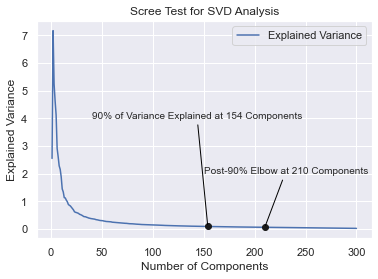

In [18]:
# Obtain Explained Variance
expl_variance = scree_matrix.explained_variance_

# Find Elbow Point
kneedle = KneeLocator(np.arange(ninety_threshold + 1, len(expl_variance)+ 1), 
                      expl_variance[ninety_threshold:], curve='convex', 
                      direction='decreasing')

elbow_location = kneedle.elbow

# Plot Elbow
sns.set_theme()

plt.plot(np.arange(1, len(expl_variance)+1),
         expl_variance[0:],
         label = "Explained Variance")

# Add Title and Axis Labels
plt.title("Scree Test for SVD Analysis")
plt.ylabel("Explained Variance")
plt.xlabel("Number of Components")
plt.legend()

# Add Annotation and Point to Show Location of 90%
plt.annotate(f"90% of Variance Explained at {ninety_threshold + 1} Components", 
             xy=(ninety_threshold + 1, expl_variance[ninety_threshold]),
             xytext=(40, 4),
             arrowprops=dict(arrowstyle="-",
                             color = "black"), fontsize=10)

plt.plot(ninety_threshold + 1, expl_variance[ninety_threshold], "ko",
         label = "Elbow Point")

# Add Annotation and Point to Show Location of Elbow
plt.annotate(f"Post-90% Elbow at {elbow_location} Components", 
             xy=(elbow_location, expl_variance[elbow_location - 1]),
             xytext=(150, 2),
             arrowprops=dict(arrowstyle="-",
                             color = "black"), fontsize=10)

plt.plot(elbow_location, expl_variance[elbow_location - 1], "ko",
         label = "Elbow Point")

#### Optimized SVD

Plotting the explained variance against the number of SVD components, we find that 90% of variance is in fact explained far past the plot's actual elbow. Finding the "post-90%" elbow and identifying it on the plot shows that it is located on the tail of the plot. It also consists of only 4 components more than the 90% variance point. Consequently, we decide to stick to our minimum variance point of 156 components with at least 90% variance as opposed to the 160 of the post-90% elbow. We believe the returns to making the model more complex are not sufficient.

We run the truncated SVD with 156 components.

In [19]:
# Create Instance of SVD with 2515 Components
svd_opt = TruncatedSVD(n_components=156, random_state = 70)

# Fit to the Matrix
lat_matrix = svd_opt.fit_transform(vector_df)

In [20]:
# Turn Into DataFrame
lat_df = pd.DataFrame(lat_matrix)

# Add Movie Labels
titles_df = pd.concat([pd.Series(vector_df.index), lat_df], axis = 1)

# Cosine Similarity
cos_similarity = cosine_similarity(titles_df.iloc[:, 1:])

content_similarity_df = pd.DataFrame(cos_similarity, index = titles_df["title"], 
             columns = titles_df["title"])

In [21]:
content_similarity_df.head()

title,Space Engineers,Minion Masters,Hearts of Iron IV,Clone Drone in the Danger Zone,Graveyard Keeper,The Sims™ 3,resident evil 4 (2005),Keep Talking and Nobody Explodes,Town of Salem,Sid Meier’s Civilization® VI,...,Atelier Totori ~The Adventurer of Arland~ DX,Resident Evil 7 Biohazard,Injustice™ 2,Tropico 6,Hot Dogs Horseshoes & Hand Grenades,Atelier Meruru ~The Apprentice of Arland~ DX,MONOPOLY® PLUS,Cuphead,Portal 2,Left 4 Dead
title,,,,,,,,,,,,,,,,,,,,,
Space Engineers,1.000000,0.326985,0.423636,0.445325,0.356890,0.320880,0.357140,0.300331,0.358437,0.322650,...,0.191020,0.322915,0.369449,0.410256,0.313068,0.192742,0.326906,0.310684,0.321069,0.382499
Minion Masters,0.326985,1.000000,0.423495,0.366232,0.164800,0.148007,0.194057,0.348506,0.456572,0.453992,...,0.141443,0.157414,0.407267,0.374336,0.177156,0.143561,0.356725,0.278109,0.230857,0.333535
Hearts of Iron IV,0.423636,0.423495,1.000000,0.302432,0.260829,0.334723,0.299793,0.313791,0.483929,0.647302,...,0.189311,0.228625,0.354099,0.530277,0.163305,0.184480,0.386632,0.303469,0.275706,0.315688
Clone Drone in the Danger Zone,0.445325,0.366232,0.302432,1.000000,0.349222,0.210896,0.456061,0.316401,0.380308,0.289581,...,0.188783,0.342058,0.582647,0.377760,0.317636,0.195159,0.368256,0.458254,0.424234,0.443837
Graveyard Keeper,0.356890,0.164800,0.260829,0.349222,1.000000,0.352480,0.377768,0.186847,0.233841,0.237240,...,0.339333,0.331692,0.328563,0.422788,0.252272,0.340281,0.205212,0.296997,0.335512,0.233641


In [22]:
# Save df to file
content_similarity_df.to_csv('data/content_base.csv', index = True)

## User Similarity

In [ ]:
# Import the final DataFrame
user_df = pd.read_csv("data/final_df.csv", 
                       usecols = ["appid", "title", "user_id",
                                 "y"])

In [ ]:
# Turn Booleans to Integers
user_df["y"] = user_df["y"].astype(int).replace(0, -1)

In [ ]:
# Create Pivot Table
rec_pivot = user_df.pivot_table(index = "user_id", columns = "title",
                   values = "y", fill_value = 0)

In [ ]:
rec_pivot

## Feature Creation

Finally, we create a brand new feature in our final_df. 

In [2]:
content_similarity_df = pd.read_csv("data/content_base.csv", index_col = "name")

FileNotFoundError: [Errno 2] No such file or directory: 'data/content_base.csv'

In [ ]:
for index, row in final_df.iterrows():
    
    # Identify User ID, Rows, and Title
    user_id = row['user_id']
    user_rows = final_df[final_df['user_id'] == user_id]
    user_titles = user_rows['title']
    
    # Create Empty List
    similarity_scores = []
    
    # Iterate Through Titles
    for iter_title in user_titles:
        
        # Define Rows Which are Not in Iteration and Title
        other_rows = user_rows[user_rows['title'] != iter_title]
        other_titles = other_rows['title']
        
        # If There are None, do Nothing and Continue
        if len(other_titles) == 0:
            continue
        
        # Create Empty List of Similarities
        similarities_list = []
        
        # Iterate Through Other Titles
        for other_title in other_titles:
            
            # Continue if Equal to Iter_Titles
            if other_title == iter_title:
                continue
            
            # Identify Similarity of Other Title to Iter Title
            try:
                similarity = content_similarity_df.loc[iter_title, other_title]
                
            except KeyError:
                continue
            
            # If Review is Positive Maintain Score, if Negative Negativize Score
            if final_df.loc[(final_df['user_id'] == user_id) & (final_df['title'] == other_title), 'y'].values[0] == 0:
                similarity *= -1
            
            # Append Similarity to List
            similarities_list.append(similarity)
                
        # If there are elements in this list        
        if len(similarities_list) > 0:
            avg_sim = np.average(similarities_list) 
            final_df.at[index, 'similarity'] = avg_sim
            
        # If there are no elements, add None
        else:
            final_df.at[index, 'similarity'] = None